In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
import random
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})
import pandas as pd
import numpy as np
import os

from ipywidgets import interact
import ipywidgets as widgets
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
%reload_ext autoreload
%autoreload 2

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


In [2]:
from ipyfilechooser import FileChooser
path_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/'), '')
display(path_chooser)

FileChooser(path='/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc', filename='', title='HTML(value='', la…

In [42]:
pathtovectnpy = path_chooser.selected
print(pathtovectnpy)

/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/24_8_128_128_flow0_norm0_dir1_clstm8_conv1_lstm8/2022-01-13_10_48/moved/vects_f0.npy


In [43]:
nda = np.load(pathtovectnpy)
print(nda.shape)

(25, 40, 16, 64, 64, 3)


In [44]:
nda_temp = nda[0]
nda_temp = np.linalg.norm(nda_temp, axis=-1)
print(nda_temp.shape)

(40, 16, 64, 64)


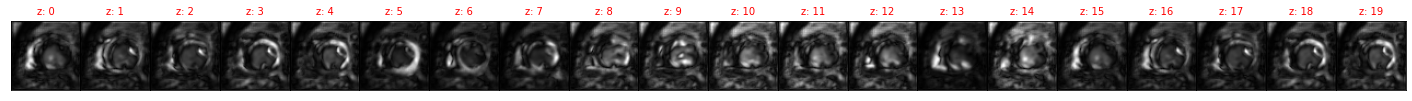

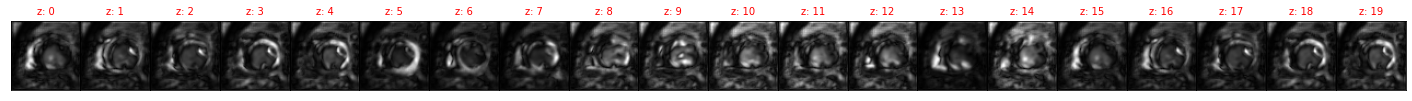

In [45]:
from src.visualization.Visualize import show_2D_or_3D
show_2D_or_3D(nda_temp[:,8])

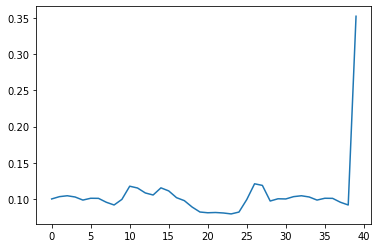

In [46]:
nda_1d = nda_temp.mean(axis=(1,2,3))
plt.plot(nda_1d)

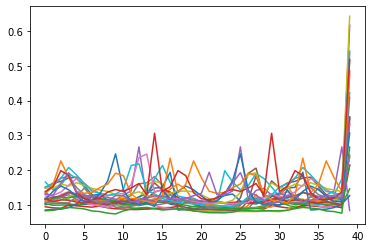

In [47]:
ndas = []
for n in nda:
    ndas.append(np.linalg.norm(n, axis=-1).mean(axis=(1,2,3)))

for n in ndas:
    _ = plt.plot(n)

# compare excel with original phase for ED and ES

In [23]:
patient_paths = sorted(glob.glob('/mnt/ssd/data/acdc/orig_save/all/*/Info.cfg'))
print(len(patient_paths))
print(patient_paths[0:5])

100
['/mnt/ssd/data/acdc/orig_save/all/patient001/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient002/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient003/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient004/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient005/Info.cfg']


In [24]:
patient_paths = [p for p in patient_paths if '090' not in p]
print(len(patient_paths))
print(patient_paths[0:5])

99
['/mnt/ssd/data/acdc/orig_save/all/patient001/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient002/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient003/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient004/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient005/Info.cfg']


In [25]:
patients = [os.path.basename(os.path.dirname(p)) for p in patient_paths]
print(len(patients))
print(patients[0:5])

99
['patient001', 'patient002', 'patient003', 'patient004', 'patient005']


In [26]:
file_4d = glob.glob(os.path.join(os.path.dirname(patient_paths[94]), '*4d.nii.gz'))
print(file_4d)
frames_total = sitk.GetArrayFromImage(sitk.ReadImage(file_4d[0])).shape[0]
print(frames_total)

['/mnt/ssd/data/acdc/orig_save/all/patient096/patient096_4d.nii.gz']
15


In [27]:
import yaml
def read_cfg_file(f):
    """Helper to open cfg files"""
    with open(f, 'r') as yml_file:
        cfg = yaml.load(yml_file, Loader=yaml.FullLoader)
    return cfg

def get_idx(cfg_f):
    patient = os.path.basename(os.path.dirname(cfg_f))
    patient_short = patient.split('patient')[1]
    cfg = read_cfg_file(cfg_f)
    file_4d = glob.glob(os.path.join(os.path.dirname(cfg_f), '*4d.nii.gz'))
    frames_total = sitk.GetArrayFromImage(sitk.ReadImage(file_4d[0])).shape[0]
    frames_total_cfg = int('{:02}'.format(cfg.get('NbFrame', 'NOPHASE')))
    if frames_total != frames_total_cfg:
        print('patient: {} total: {}, total cfg: {}'.format(patient_short, frames_total, frames_total_cfg))
    frame_ed = '{:02}'.format(cfg.get('ED', 'NOPHASE'))
    frame_es = '{:02}'.format(cfg.get('ES', 'NOPHASE'))
    return patient_short, int(frame_ed), int(frame_es), int(frames_total)

In [28]:
idxs = [get_idx(c) for c in patient_paths]

In [29]:
df = pd.DataFrame(idxs, columns=['patient', 'ED#', 'ES#', 'total'])
df

,patient,ED#,ES#,total
0,001,1,12,30
1,002,1,12,30
2,003,1,15,30
3,004,1,15,28
4,005,1,13,30
...,...,...,...,...
94,096,1,8,15
95,097,1,11,30
96,098,1,9,22
97,099,1,9,19


In [30]:
df_phase_file = '/mnt/ssd/data/acdc/original/SAx_3D_dicomTags_phase.csv'
df_phase = pd.read_csv(df_phase_file,dtype={'patient':str, 'ED#':int, 'MS#':int, 'ES#':int, 'PF#':int, 'MD#':int})
df_phase = df_phase[['patient', 'ED#','ES#']]
df_phase

,patient,ED#,ES#
0,001,29,12
1,002,29,11
2,003,28,14
3,004,0,13
4,005,29,12
...,...,...,...
94,096,0,6
95,097,28,10
96,098,21,8
97,099,0,6


In [31]:
df_phase['total'] = df['total']
df_phase['ED_orig'] = df['ED#']
df_phase['ES_orig'] = df['ES#']

df_phase['ED_orig'] = df_phase['ED_orig'] -1
df_phase['ES_orig'] = df_phase['ES_orig'] -1
df_phase['ED_diff'] = df_phase['ED#'] == df_phase['ED_orig']
df_phase['ES_diff'] = df_phase['ES#'] == df_phase['ES_orig']

In [32]:
df_phase['ED_diff'].sum()

21

In [33]:
df_phase['ES_diff'].sum()

51

In [34]:
df_phase['ED#'][0], df_phase['ED_orig'][0], df_phase['total'][0]

(29, 0, 30)

In [35]:
import tensorflow as tf
def get_min_distance(vals):

    smaller = tf.reduce_min(vals[0:2], keepdims=True)
    bigger = tf.reduce_max(vals[0:2], keepdims=True)
    mod = vals[2]

    diff = bigger - smaller
    diff_ring = tf.math.abs(mod - bigger + smaller)# we need to use the abs to avoid 0 - 0
    min_diff = tf.reduce_min(tf.stack([diff, diff_ring]))
    tf.math.greater_equal(min_diff, 0) # this is an int, as we measure the distance between buckets for the metric
    return min_diff


ed_dist_lambda = lambda x : get_min_distance([x['ED#'], x['ED_orig'], x['total']]).numpy()
es_dist_lambda = lambda x : get_min_distance([x['ES#'], x['ES_orig'], x['total']]).numpy()

In [36]:
df_phase['ED_dist'] = df_phase.apply(ed_dist_lambda, axis=1)
df_phase['ES_dist'] = df_phase.apply(es_dist_lambda, axis=1)

In [37]:
df_phase

,patient,ED#,ES#,total,ED_orig,ES_orig,ED_diff,ES_diff,ED_dist,ES_dist
0,001,29,12,30,0,11,False,False,1,1
1,002,29,11,30,0,11,False,True,1,0
2,003,28,14,30,0,14,False,True,2,0
3,004,0,13,28,0,14,True,False,0,1
4,005,29,12,30,0,12,False,True,1,0
...,...,...,...,...,...,...,...,...,...,...
94,096,0,6,15,0,7,True,False,0,1
95,097,28,10,30,0,10,False,True,2,0
96,098,21,8,22,0,8,False,True,1,0
97,099,0,6,19,0,8,True,False,0,2


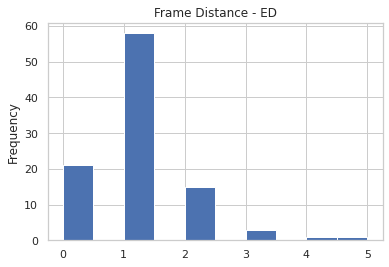

In [53]:
ax = df_phase['ED_dist'].plot(kind='hist')
_ = ax.set_title('Frame Distance - ED')

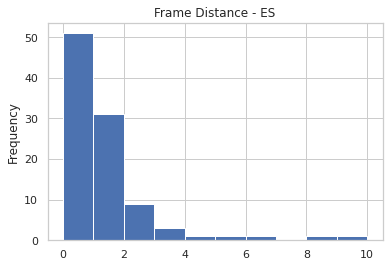

In [51]:
ax = df_phase['ES_dist'].plot(kind='hist')
_ =ax.set_title('Frame Distance - ES')

<AxesSubplot:>

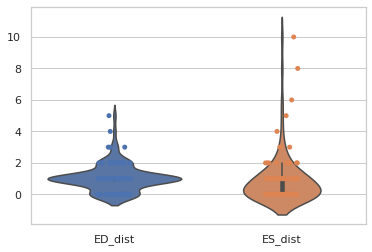

In [50]:
import seaborn as sb
sb.set_theme(style="whitegrid")
sb.violinplot(data=df_phase[['ED_dist','ES_dist']])
sb.stripplot(data=df_phase[['ED_dist','ES_dist']])

In [44]:
from ipywidgets import interact, widgets
@interact
def inspect_frame_diffs(patients='', 
                        ed_diff=(widgets.IntSlider(min=0,max=15,step=1,value=15)),
                        es_diff=(widgets.IntSlider(min=0,max=15,step=1,value=15)),
                       greater_as=False):
    temp = df_phase.copy()
    if len(patients) > 0:
        temp = df_phase[df_phase['patient'].str.contains(patients)]
    if greater_as:
        temp = temp[(temp['ED_dist']>=ed_diff) | (temp['ES_dist']>=es_diff)]
    else:
        temp = temp[(temp['ED_dist']<=ed_diff) | (temp['ES_dist']<=es_diff)]
    print(temp.shape)
    return temp

interactive(children=(Text(value='', description='patients'), IntSlider(value=15, description='ed_diff', max=1…